# Accuracy Vs Mag SDSS Spec Test Set

In this notebook we examine the accuracy as a function of magnitude for sources with spectroscopic classifications from SDSS. The SDSS set contains > 3M sources, and, as we will show below, there is a bias towards point sources at the faint end (due to the large number of faint QSOs in the SDSS spectroscopic data). 

This bias suggests that the SDSS `photo` classifications perform better than our new PS1 ML model, however, if we correct for the SDSS bias by selecting bootstrap samples with fewer stars than galaxies at $m > 21$, as is observed in nature at high galactic latitudes, it becomes clear that the ML model greatly outperforms all other available models for star-galaxy separation.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator
from matplotlib import rcParams
import seaborn as sns
rcParams["font.family"] = "sans-serif"
rcParams['font.sans-serif'] = ['DejaVu Sans']
%matplotlib notebook
from astropy.table import Table
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, accuracy_score, auc, make_scorer
from sklearn.neighbors import KernelDensity
from scipy import stats

In [2]:
hst_tbl = Table.read("HST_COSMOS_features_adamamiller.fit").to_pandas()
sdss_tbl = Table.read("sdssSP_MLfeats_adamamiller.fit").to_pandas()

For a fair comparison between the 4 models under consideration (the PS1 ML model, the PS1 simple model, the SDSS model, and the PS1 `iPSFMag - iKronMag`) we must generate a subset of sources that has a classification from each model for the test set. Ultimately, the test set has **3592940** sources.

Following Miller+17 we exclude QSOs with $z < 1$ from the test set as many of these sources are AGN with resolved host galaxies (this is 133856 sources total). We also exclude galaxies with $z < 10^{-4}$, which is unphysical and represents spectra with unreliable classifications (this is 13261 sources total).

In [3]:
hst_det = np.where(hst_tbl.nDetections > 0)
hst_kron_mag = np.array(-2.5*np.log10(hst_tbl['wwKronFlux'].ix[hst_det]/3631))

sdss_det = np.where(sdss_tbl.nDetections > 0)
sdss_photo_det = np.logical_and(np.isfinite(sdss_tbl.type),
                                sdss_tbl.countRatio > 0)
sdss_in_common = np.logical_and(np.isfinite(sdss_tbl.iPSFminusKron), 
                                sdss_photo_det)
low_z_gal = np.logical_and(sdss_tbl.z < 1e-4, sdss_tbl['class'] == 'GALAXY')
low_z_qso = np.logical_and(sdss_tbl.z < 1, sdss_tbl['class'] == '   QSO')

sdss_test_set = sdss_in_common & ~low_z_gal & ~low_z_qso

Train the ML model to provide classifications for the sources with SDSS spectra.

In [4]:
features = ['wwpsfChiSq', 'wwExtNSigma', 'wwpsfLikelihood',
            'wwPSFKronRatio', 'wwPSFKronDist',  'wwPSFApRatio',
            'wwmomentRH', 'wwmomentXX', 'wwmomentXY', 'wwmomentYY', 
            'wwKronRad']

# 'wwApFlux', 'wwPSFFlux', 'wwKronFlux' --> not included

In [5]:
hst_ml_train_X = np.array(hst_tbl[features].ix[hst_det])
hst_ml_train_y = np.array(hst_tbl["MU_CLASS"].ix[hst_det] - 1)
sdss_ml_test_X = np.array(sdss_tbl[features].ix[sdss_test_set])
sdss_spec_class = np.array(sdss_tbl['class'].ix[sdss_test_set])
sdss_ml_test_y = np.ones_like(sdss_spec_class).astype(int)
sdss_ml_test_y[np.where(sdss_spec_class == "GALAXY")] = 0

In [6]:
rf_clf = RandomForestClassifier(n_estimators = 250, 
                                min_samples_leaf = 1, 
                                max_features= 5, 
                                n_jobs=-1)
rf_clf.fit(hst_ml_train_X, hst_ml_train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=5, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=250, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [7]:
sdss_preds = rf_clf.predict_proba(sdss_ml_test_X)

## Compare the ROC curves of the different models

In [8]:
ml_fpr, ml_tpr, ml_thresh = roc_curve(sdss_ml_test_y, sdss_preds[:,1])
sdss_fpr, sdss_tpr, sdss_thresh = roc_curve(sdss_ml_test_y, sdss_tbl["countRatio"].ix[sdss_test_set])
simple_fpr, simple_tpr, simple_thresh = roc_curve(sdss_ml_test_y, sdss_tbl["wwPSFKronDist"].ix[sdss_test_set])
ps1_fpr, ps1_tpr, ps1_thresh = roc_curve(sdss_ml_test_y, -1.*sdss_tbl["iPSFminusKron"].ix[sdss_test_set])

<IPython.core.display.Javascript object>


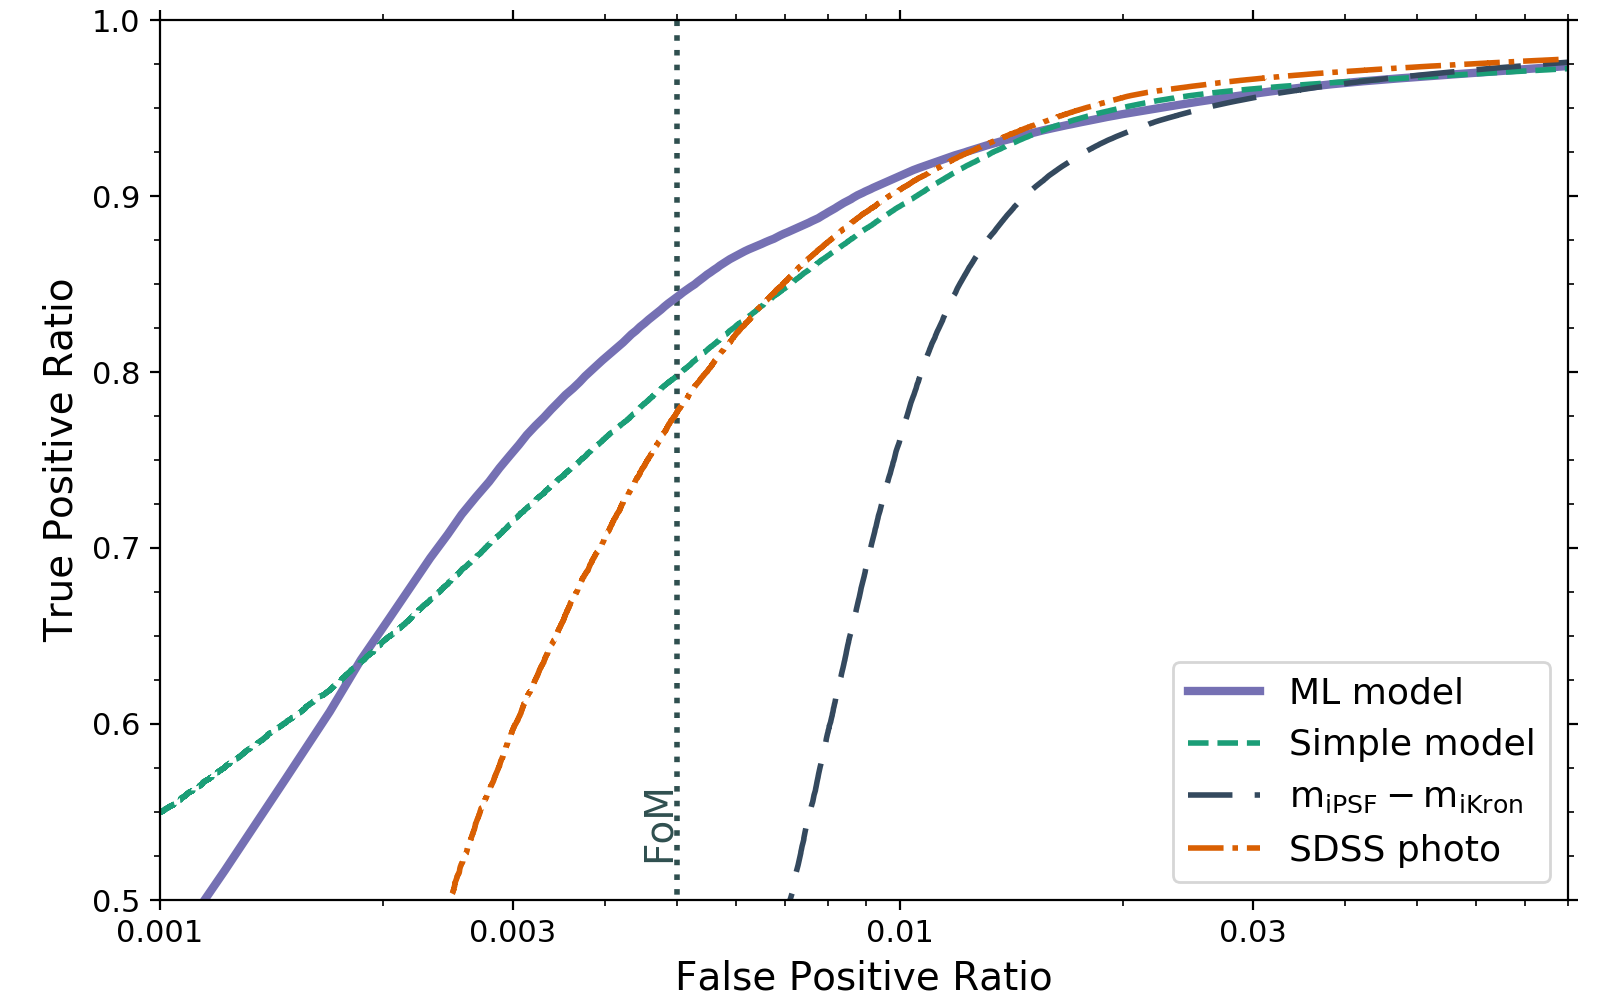

In [33]:
# apple colors
color_dict = {'ml': "#0072c6", #"#1C1858",
              'sdss': "#5BC236", #"#00C78E",
              'simple': "#C864AF", #"#C70039",
              'ps1': "#C65400"}

# color blind friendly
color_dict = {'ml': '#0072b2', 
              'sdss': '#d55e00', 
              'simple': '#cc79a7',
              'ps1': '#009e73'}

# color brewer
color_dict = {'ml': '#7570b3', 
              'sdss': '#d95f02', 
              'simple': '#1b9e77',
              'ps1': '#34495e'}

ls_dict = {'ml': '-', 
              'sdss': '-.', 
              'simple': '--',
              'ps1': '--'}
fig, ax = plt.subplots(figsize=(8, 5))


ax.plot(ml_fpr, ml_tpr, 
        ls=ls_dict['ml'], lw=3,
        color=color_dict['ml'], label='ML model')
ax.plot(simple_fpr, simple_tpr,
        ls=ls_dict['simple'], lw=2,
        color=color_dict['simple'], label='Simple model')
ax.plot(ps1_fpr, ps1_tpr,
        ls =ls_dict['ps1'], lw=2, dashes=(8, 4),
        color=color_dict['ps1'], label=r'm$_{\rm iPSF}-$m$_{\rm iKron}$')
ax.plot(sdss_fpr, sdss_tpr,
        ls = ls_dict['sdss'], lw=2,
        color=color_dict['sdss'], label='SDSS photo')
# ax.plot(sdss_fpr[np.argmin(np.abs(sdss_thresh-10**(-0.185/2.5)))], 
#         sdss_tpr[np.argmin(np.abs(sdss_thresh-10**(-0.185/2.5)))], '*', color="black")
ax.vlines([5e-3], 1e-3, 1, 
          linestyles=":", 
          color='DarkSlateGrey', lw=2)
ax.text(5e-3, 0.55, 'FoM', 
        color='DarkSlateGrey', 
        rotation=90, ha="right", fontsize=14)

ax.set_ylim(0.5, 1)
ax.set_xlim(1e-3, 8e-2)
ax.set_xscale("log")
ax.tick_params(which="both", top=True, right=True, labelsize=11)
ax.set_xlabel('False Positive Ratio', fontsize=14)
ax.set_ylabel('True Positive Ratio', fontsize=14)

ax.set_xticks([1e-3, 3e-3, 1e-2, 3e-2])
ax.set_xticklabels([1e-3, 3e-3, 1e-2, 3e-2])
ax.yaxis.set_minor_locator(MultipleLocator(0.025))

ax.legend(loc=4, fontsize=13)

fig.subplots_adjust(top=0.98,right=0.98,left=0.1,bottom=0.1)
# fig.savefig('~/Desktop/ROC_sdss_spec.png')
# fig.savefig('ROC_sdss_spec.pdf')

Using the SDSS spectroscopic sample as a test set it is clear that the ML model provides the best FoM. However, at $\mathrm{FPR} \approx 0.015$ each of the 3 other models cross over the ML model ROC curve and provide a better performance. This is coupled with an unusual kink at $\mathrm{FPR} \approx 0.025$ that suggests something unusual is going on.

## Accuracy as a Function of Magnitude

We further explore the kink in the ROC curve by examining the accuracy as a function of magnitude. 

In [10]:
ml_decision_thresh = 0.5
sdss_decision_thresh = 10**(-0.185/2.5)
simple_decision_thresh = 9.2e-07 #  maximize acc on training set
ps1_decision_thresh = 0.05

ml_labels = np.logical_not(sdss_preds[:,1] < ml_decision_thresh).astype(int)
sdss_labels = np.logical_not(np.array(sdss_tbl["countRatio"].ix[sdss_test_set]) < sdss_decision_thresh).astype(int)
simple_labels = np.logical_not(np.array(sdss_tbl["wwPSFKronDist"].ix[sdss_test_set]) < simple_decision_thresh).astype(int)
ps1_labels = np.logical_not(-1*np.array(sdss_tbl["iPSFminusKron"].ix[sdss_test_set]) < ps1_decision_thresh).astype(int)

In [11]:
binwidth = 0.5
Nboot = 100
mag_array = np.arange(13 , 23+binwidth, binwidth)
kron_mag = np.array(-2.5*np.log10(sdss_tbl['wwKronFlux'].ix[sdss_test_set]/3631))

sdss_acc_arr = np.zeros_like(mag_array)
simple_acc_arr = np.zeros_like(mag_array)
ps1_acc_arr = np.zeros_like(mag_array)
ml_acc_arr = np.zeros_like(mag_array)

sdss_boot_scatt = np.vstack((np.zeros_like(mag_array), np.zeros_like(mag_array)))
simple_boot_scatt = np.vstack((np.zeros_like(mag_array), np.zeros_like(mag_array)))
ps1_boot_scatt = np.vstack((np.zeros_like(mag_array), np.zeros_like(mag_array)))
ml_boot_scatt = np.vstack((np.zeros_like(mag_array), np.zeros_like(mag_array)))


for bin_num, binedge in enumerate(mag_array):
    bin_sources = np.where((kron_mag >= binedge) & (kron_mag < binedge + binwidth))
    sdss_acc_arr[bin_num] = accuracy_score(sdss_ml_test_y[bin_sources], 
                                           sdss_labels[bin_sources])
    simple_acc_arr[bin_num] = accuracy_score(sdss_ml_test_y[bin_sources], 
                                             simple_labels[bin_sources])
    ps1_acc_arr[bin_num] = accuracy_score(sdss_ml_test_y[bin_sources], 
                                          ps1_labels[bin_sources])
    ml_acc_arr[bin_num] = accuracy_score(sdss_ml_test_y[bin_sources], 
                                         ml_labels[bin_sources])
    sdss_boot_acc = np.empty(Nboot)
    simple_boot_acc = np.empty_like(sdss_boot_acc)
    ps1_boot_acc = np.empty_like(sdss_boot_acc)
    ml_boot_acc = np.empty_like(sdss_boot_acc)
    for i in range(Nboot):
        boot_sources = np.random.choice(bin_sources[0], len(bin_sources[0]), 
                                        replace=True)
        sdss_boot_acc[i] = accuracy_score(sdss_ml_test_y[boot_sources], 
                                           sdss_labels[boot_sources])
        simple_boot_acc[i] = accuracy_score(sdss_ml_test_y[boot_sources], 
                                             simple_labels[boot_sources])
        ps1_boot_acc[i] = accuracy_score(sdss_ml_test_y[boot_sources], 
                                          ps1_labels[boot_sources])
        ml_boot_acc[i] = accuracy_score(sdss_ml_test_y[boot_sources], 
                                         ml_labels[boot_sources])

    sdss_boot_scatt[:,bin_num] = np.percentile(sdss_boot_acc, [16, 84])
    simple_boot_scatt[:,bin_num] = np.percentile(simple_boot_acc, [16, 84])
    ps1_boot_scatt[:,bin_num] = np.percentile(ps1_boot_acc, [16, 84])
    ml_boot_scatt[:,bin_num] = np.percentile(ml_boot_acc, [16, 84])

### Calculate the KDE for the distributions for plotting purposes

In [12]:
kde_grid = np.linspace(13,23.5,200)
sdss_stars = np.where(sdss_ml_test_y == 1)
sdss_gal = np.where(sdss_ml_test_y == 0)
sdss_kde_gal_norm = len(sdss_gal[0])/len(sdss_ml_test_y)
sdss_kde_star_norm = 1 - sdss_kde_gal_norm

kde_sdss = KernelDensity(bandwidth=1.059*np.std(kron_mag, ddof=1)*len(kron_mag)**(-0.2),
                         rtol=1E-4)
kde_sdss.fit(kron_mag[:, np.newaxis])

kde_sdss_stars = KernelDensity(bandwidth=1.059*np.std(kron_mag[sdss_stars], ddof=1)*len(kron_mag[sdss_stars])**(-0.2),
                               rtol=1E-4)
kde_sdss_stars.fit(kron_mag[sdss_stars[0], np.newaxis])

kde_sdss_gal = KernelDensity(bandwidth=1.059*np.std(kron_mag[sdss_gal], ddof=1)*len(kron_mag[sdss_gal])**(-0.2),
                             rtol=1E-4)
kde_sdss_gal.fit(kron_mag[sdss_gal[0], np.newaxis])

pdf_sdss = np.exp(kde_sdss.score_samples(kde_grid[:, np.newaxis]))
pdf_sdss_stars = np.exp(kde_sdss_stars.score_samples(kde_grid[:, np.newaxis]))
pdf_sdss_gal = np.exp(kde_sdss_gal.score_samples(kde_grid[:, np.newaxis]))

<IPython.core.display.Javascript object>


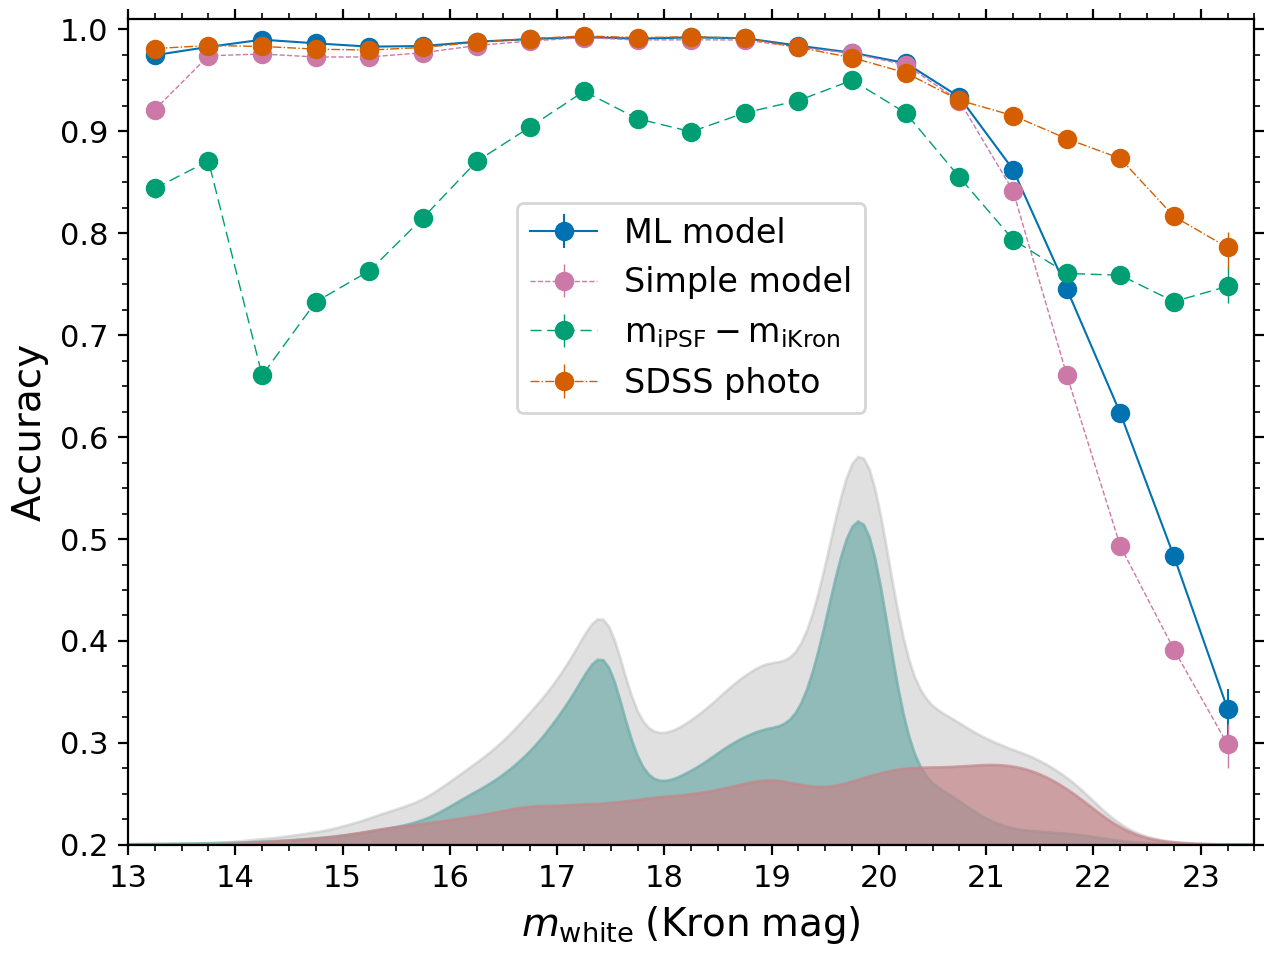

In [13]:
mag_bin_centers = mag_array + binwidth/2
cmap_star = sns.cubehelix_palette(rot=0.5, light=0.7,dark=0.3,as_cmap=True)
cmap_gal = sns.cubehelix_palette(start=0.3,rot=-0.5,light=0.7,dark=0.3,as_cmap=True)

fig, ax = plt.subplots()

ax.errorbar(mag_bin_centers, ml_acc_arr, 
            yerr=np.abs(ml_boot_scatt - ml_acc_arr), 
            ls =ls_dict['ml'], lw=.75, fmt='o',
            color=color_dict['ml'], label="ML model")
ax.errorbar(mag_bin_centers, simple_acc_arr, 
            yerr=np.abs(simple_boot_scatt - simple_acc_arr), 
            ls =ls_dict['simple'], lw=.5, fmt='o',
            color=color_dict['simple'], label="Simple model")
ax.errorbar(mag_bin_centers, ps1_acc_arr, 
            yerr=np.abs(ps1_boot_scatt - ps1_acc_arr), 
            ls =ls_dict['ps1'], lw=.5, dashes=(8, 4), fmt='o',
            color=color_dict['ps1'], label=r'm$_{\rm iPSF}-$m$_{\rm iKron}$')
ax.errorbar(mag_bin_centers, sdss_acc_arr, 
            yerr=np.abs(sdss_boot_scatt - sdss_acc_arr), 
            ls=ls_dict['sdss'], lw=.5, fmt='o',
            color=color_dict['sdss'], label="SDSS photo")

# add KDE plots
ax.fill(kde_grid, pdf_sdss + 0.2, alpha=0.4, color="0.7")
ax.fill(kde_grid, pdf_sdss_gal*sdss_kde_gal_norm + 0.2, alpha=0.7, color=cmap_gal(0.25))
ax.fill(kde_grid, pdf_sdss_stars*sdss_kde_star_norm + 0.2, alpha=0.7, color=cmap_star(0.25))

ax.set_ylim(0.2,1.01)
ax.set_xlim(13, 23.5)
ax.tick_params(which="both", top=True, right=True, labelsize=11)
ax.set_xlabel('$m_\mathrm{white} \; (\mathrm{Kron \; mag})$', fontsize=14)
ax.set_ylabel('Accuracy', fontsize=14)

ax.yaxis.set_minor_locator(MultipleLocator(0.025))
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_minor_locator(MultipleLocator(0.25))

ax.legend(bbox_to_anchor=(0.5, 0.65),
          loc=10, fontsize=12)

fig.subplots_adjust(top=0.98,right=0.98,left=0.1,bottom=0.12)

## Classifier Bias vs. Magnitude

The above accuracy vs. magnitude plot shows that the machine learning model provides a poor performance at classifying faint sources as evaluated by the SDSS spectroscopic sample. However, the SDSS spectroscopic sample is baised in that faint stars are more prevalent than faint galaxies (see the KDEs above).

Here we examine the accuracy of the SDSS `photo` classifications of stars and galaxies separately and the ML model of stars and galaxies separately to identify if any biases are present in the classifiers themselves.

In [14]:
binwidth = 0.5
Nboot = 100

# bootstrap star arrays
sdss_star_acc_arr = np.zeros_like(mag_array)
simple_star_acc_arr = np.zeros_like(mag_array)
ps1_star_acc_arr = np.zeros_like(mag_array)
ml_star_acc_arr = np.zeros_like(mag_array)

sdss_star_boot_scatt = np.vstack((np.zeros_like(mag_array), np.zeros_like(mag_array)))
simple_star_boot_scatt = np.vstack((np.zeros_like(mag_array), np.zeros_like(mag_array)))
ps1_star_boot_scatt = np.vstack((np.zeros_like(mag_array), np.zeros_like(mag_array)))
ml_star_boot_scatt = np.vstack((np.zeros_like(mag_array), np.zeros_like(mag_array)))

# bootstrap galaxy arrays
sdss_gal_acc_arr = np.zeros_like(mag_array)
simple_gal_acc_arr = np.zeros_like(mag_array)
ps1_gal_acc_arr = np.zeros_like(mag_array)
ml_gal_acc_arr = np.zeros_like(mag_array)

sdss_gal_boot_scatt = np.vstack((np.zeros_like(mag_array), np.zeros_like(mag_array)))
simple_gal_boot_scatt = np.vstack((np.zeros_like(mag_array), np.zeros_like(mag_array)))
ps1_gal_boot_scatt = np.vstack((np.zeros_like(mag_array), np.zeros_like(mag_array)))
ml_gal_boot_scatt = np.vstack((np.zeros_like(mag_array), np.zeros_like(mag_array)))

for bin_num, binedge in enumerate(mag_array):
    bin_stars = np.where((kron_mag >= binedge) & (kron_mag < binedge + binwidth) & 
                         (sdss_ml_test_y == 1))
    sdss_star_acc_arr[bin_num] = accuracy_score(sdss_ml_test_y[bin_stars], 
                                           sdss_labels[bin_stars])
    simple_star_acc_arr[bin_num] = accuracy_score(sdss_ml_test_y[bin_stars], 
                                             simple_labels[bin_stars])
    ps1_star_acc_arr[bin_num] = accuracy_score(sdss_ml_test_y[bin_stars], 
                                          ps1_labels[bin_stars])
    ml_star_acc_arr[bin_num] = accuracy_score(sdss_ml_test_y[bin_stars], 
                                         ml_labels[bin_stars])
    
    bin_gals = np.where((kron_mag >= binedge) & (kron_mag < binedge + binwidth) & 
                        (sdss_ml_test_y == 0))
    sdss_gal_acc_arr[bin_num] = accuracy_score(sdss_ml_test_y[bin_gals], 
                                           sdss_labels[bin_gals])
    simple_gal_acc_arr[bin_num] = accuracy_score(sdss_ml_test_y[bin_gals], 
                                             simple_labels[bin_gals])
    ps1_gal_acc_arr[bin_num] = accuracy_score(sdss_ml_test_y[bin_gals], 
                                          ps1_labels[bin_gals])
    ml_gal_acc_arr[bin_num] = accuracy_score(sdss_ml_test_y[bin_gals], 
                                         ml_labels[bin_gals])    
    
    # get the bootstrap accuracies
    
    sdss_star_boot_acc = np.empty(Nboot)
    simple_star_boot_acc = np.empty_like(sdss_star_boot_acc)
    ps1_star_boot_acc = np.empty_like(sdss_star_boot_acc)
    ml_star_boot_acc = np.empty_like(sdss_star_boot_acc)
    
    sdss_gal_boot_acc = np.empty_like(sdss_star_boot_acc)
    simple_gal_boot_acc = np.empty_like(sdss_gal_boot_acc)
    ps1_gal_boot_acc = np.empty_like(sdss_gal_boot_acc)
    ml_gal_boot_acc = np.empty_like(sdss_gal_boot_acc)

    for i in range(Nboot):
        star_boot_sources = np.random.choice(bin_stars[0], len(bin_stars[0]), 
                                             replace=True)
        sdss_star_boot_acc[i] = accuracy_score(sdss_ml_test_y[star_boot_sources], 
                                           sdss_labels[star_boot_sources])
        simple_star_boot_acc[i] = accuracy_score(sdss_ml_test_y[star_boot_sources], 
                                             simple_labels[star_boot_sources])
        ps1_star_boot_acc[i] = accuracy_score(sdss_ml_test_y[star_boot_sources], 
                                          ps1_labels[star_boot_sources])
        ml_star_boot_acc[i] = accuracy_score(sdss_ml_test_y[star_boot_sources], 
                                         ml_labels[star_boot_sources])
        
        gal_boot_sources = np.random.choice(bin_gals[0], len(bin_gals[0]), 
                                            replace=True)
        sdss_gal_boot_acc[i] = accuracy_score(sdss_ml_test_y[gal_boot_sources], 
                                           sdss_labels[gal_boot_sources])
        simple_gal_boot_acc[i] = accuracy_score(sdss_ml_test_y[gal_boot_sources], 
                                             simple_labels[gal_boot_sources])
        ps1_gal_boot_acc[i] = accuracy_score(sdss_ml_test_y[gal_boot_sources], 
                                          ps1_labels[gal_boot_sources])
        ml_gal_boot_acc[i] = accuracy_score(sdss_ml_test_y[gal_boot_sources], 
                                         ml_labels[gal_boot_sources])


    sdss_star_boot_scatt[:,bin_num] = np.percentile(sdss_star_boot_acc, [16, 84])
    simple_star_boot_scatt[:,bin_num] = np.percentile(simple_star_boot_acc, [16, 84])
    ps1_star_boot_scatt[:,bin_num] = np.percentile(ps1_star_boot_acc, [16, 84])
    ml_star_boot_scatt[:,bin_num] = np.percentile(ml_star_boot_acc, [16, 84])    
    
    sdss_gal_boot_scatt[:,bin_num] = np.percentile(sdss_gal_boot_acc, [16, 84])
    simple_gal_boot_scatt[:,bin_num] = np.percentile(simple_gal_boot_acc, [16, 84])
    ps1_gal_boot_scatt[:,bin_num] = np.percentile(ps1_gal_boot_acc, [16, 84])
    ml_gal_boot_scatt[:,bin_num] = np.percentile(ml_gal_boot_acc, [16, 84])    

<IPython.core.display.Javascript object>


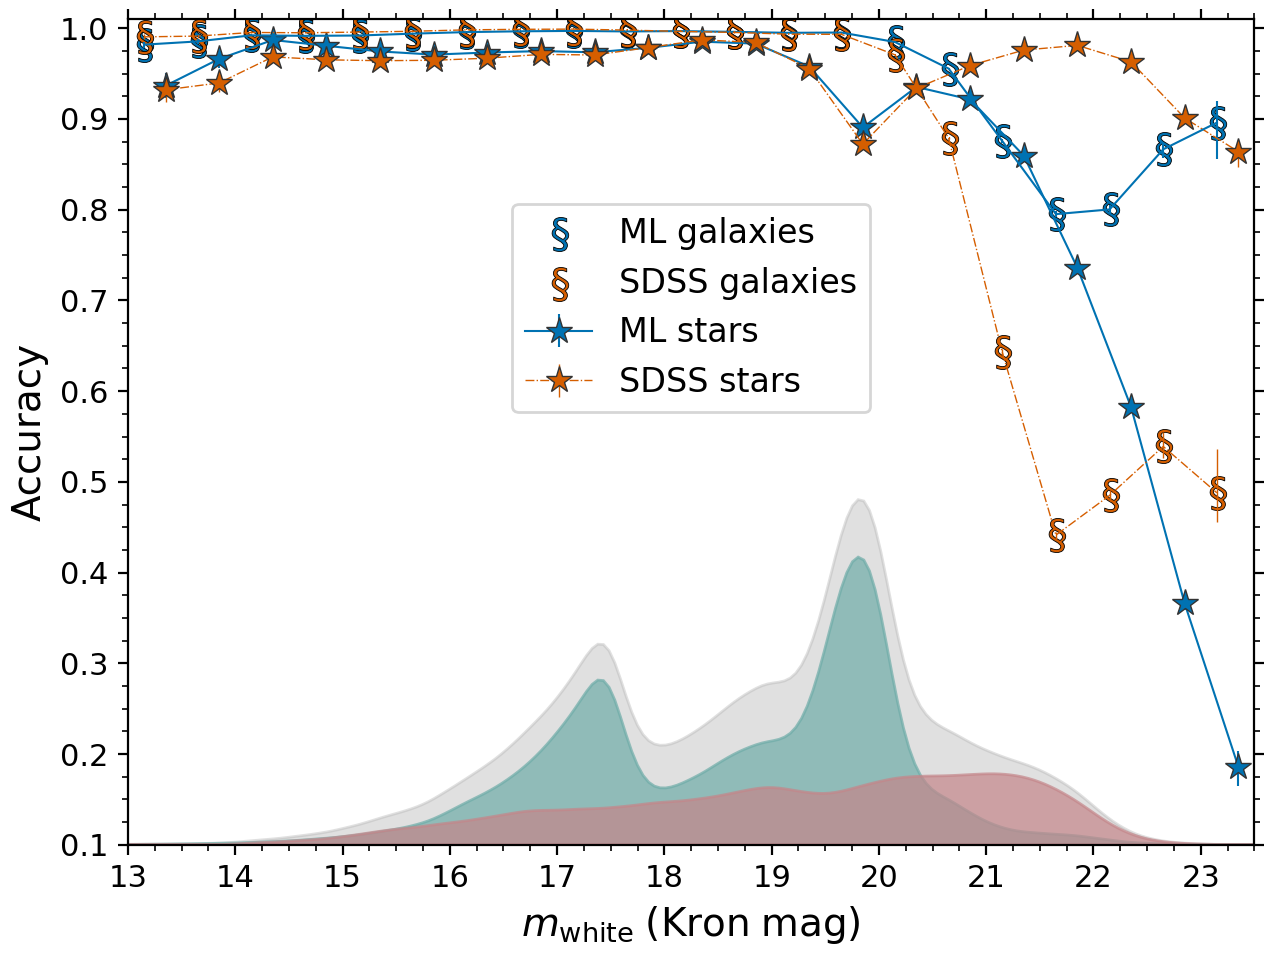

In [15]:
mag_bin_centers = mag_array + binwidth/2
cmap_star = sns.cubehelix_palette(rot=0.5, light=0.7,dark=0.3,as_cmap=True)
cmap_gal = sns.cubehelix_palette(start=0.3,rot=-0.5,light=0.7,dark=0.3,as_cmap=True)

fig, ax = plt.subplots()

ax.errorbar(mag_bin_centers+0.1, ml_star_acc_arr, 
            yerr=np.abs(ml_star_boot_scatt - ml_star_acc_arr), 
            ls =ls_dict['ml'], lw=.75, fmt='*', ms=10,
            mec="0.2", mew=0.5,
            color=color_dict['ml'], label="ML stars")
# ax.errorbar(mag_bin_centers, simple_star_acc_arr, 
#             yerr=np.abs(simple_star_boot_scatt - simple_star_acc_arr), 
#             ls =ls_dict['simple'], lw=.5, fmt='*', ms=10,
#             mec="0.2", mew=0.5,
#             color=color_dict['simple'], label="Simple model")
# ax.errorbar(mag_bin_centers, ps1_star_acc_arr, 
#             yerr=np.abs(ps1_star_boot_scatt - ps1_star_acc_arr), 
#             ls =ls_dict['ps1'], lw=.5, dashes=(8, 4), fmt='*', ms=10,
#             mec="0.2", mew=0.5,
#             color=color_dict['ps1'], label=r'm$_{\rm iPSF}-$m$_{\rm iKron}$')
ax.errorbar(mag_bin_centers+0.1, sdss_star_acc_arr, 
            yerr=np.abs(sdss_star_boot_scatt - sdss_star_acc_arr), 
            ls=ls_dict['sdss'], lw=.5, fmt='*', ms=10,
            mec="0.2", mew=0.5,
            color=color_dict['sdss'], label="SDSS stars")


ax.scatter(mag_bin_centers-0.1, ml_gal_acc_arr, 
           marker=r'$\S$', s=150, edgecolor='k', linewidths=0.3,
           color=color_dict['ml'], label="ML galaxies")
ax.errorbar(mag_bin_centers-0.1, ml_gal_acc_arr, 
            yerr=np.abs(ml_gal_boot_scatt - ml_gal_acc_arr), 
            ls =ls_dict['ml'], lw=.75, fmt=',',
            color=color_dict['ml'])
# ax.errorbar(mag_bin_centers, simple_gal_acc_arr, 
#             yerr=np.abs(simple_gal_boot_scatt - simple_gal_acc_arr), 
#             ls =ls_dict['simple'], lw=.5, fmt=',',
#             color=color_dict['simple'], label="Simple model")
# ax.errorbar(mag_bin_centers, ps1_gal_acc_arr, 
#             yerr=np.abs(ps1_gal_boot_scatt - ps1_gal_acc_arr), 
#             ls =ls_dict['ps1'], lw=.5, dashes=(8, 4), fmt=',',
#             color=color_dict['ps1'], label=r'm$_{\rm iPSF}-$m$_{\rm iKron}$')
ax.scatter(mag_bin_centers-0.1, sdss_gal_acc_arr, 
           marker=r'$\S$', s=150, edgecolor='k', linewidths=0.3,
           color=color_dict['sdss'], label="SDSS galaxies")
ax.errorbar(mag_bin_centers-0.1, sdss_gal_acc_arr, 
            yerr=np.abs(sdss_gal_boot_scatt - sdss_gal_acc_arr), 
            ls=ls_dict['sdss'], lw=.5, fmt=',',
            color=color_dict['sdss'])

# add KDE plots
ax.fill(kde_grid, pdf_sdss + 0.1, alpha=0.4, color="0.7")
ax.fill(kde_grid, pdf_sdss_gal*sdss_kde_gal_norm + 0.1, alpha=0.7, color=cmap_gal(0.25))
ax.fill(kde_grid, pdf_sdss_stars*sdss_kde_star_norm + 0.1, alpha=0.7, color=cmap_star(0.25))

ax.set_ylim(0.1,1.01)
ax.set_xlim(13, 23.5)
ax.tick_params(which="both", top=True, right=True, labelsize=11)
ax.set_xlabel('$m_\mathrm{white} \; (\mathrm{Kron \; mag})$', fontsize=14)
ax.set_ylabel('Accuracy', fontsize=14)

ax.yaxis.set_major_locator(MultipleLocator(0.1))
ax.yaxis.set_minor_locator(MultipleLocator(0.025))
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_minor_locator(MultipleLocator(0.25))

ax.legend(bbox_to_anchor=(0.5, 0.65),
          loc=10, fontsize=12)

fig.subplots_adjust(top=0.98,right=0.98,left=0.1,bottom=0.12)

## Correct Accuracy Using Realistic Distribution of Stars & Galaxies

Above we show that the ML model is more likely to classify a faint source as a galaxy, while the SDSS model is more likely to classify faint sources as stars. We now use a bootstrap technique to resample the number of stars and galaxies in each bin to better resemble what we might expect to find in nature. 

In [16]:
binwidth = 0.5
Nboot = 100

sdss_resamp_arr = np.zeros_like(mag_array)
simple_resamp_arr = np.zeros_like(mag_array)
ps1_resamp_arr = np.zeros_like(mag_array)
ml_resamp_arr = np.zeros_like(mag_array)

sdss_resamp_scatt = np.vstack((np.zeros_like(mag_array), np.zeros_like(mag_array)))
simple_resamp_scatt = np.vstack((np.zeros_like(mag_array), np.zeros_like(mag_array)))
ps1_resamp_scatt = np.vstack((np.zeros_like(mag_array), np.zeros_like(mag_array)))
ml_resamp_scatt = np.vstack((np.zeros_like(mag_array), np.zeros_like(mag_array)))

# bootstrap star arrays
sdss_star_resamp_arr = np.zeros_like(mag_array)
simple_star_resamp_arr = np.zeros_like(mag_array)
ps1_star_resamp_arr = np.zeros_like(mag_array)
ml_star_resamp_arr = np.zeros_like(mag_array)

sdss_star_resamp_scatt = np.vstack((np.zeros_like(mag_array), np.zeros_like(mag_array)))
simple_star_resamp_scatt = np.vstack((np.zeros_like(mag_array), np.zeros_like(mag_array)))
ps1_star_resamp_scatt = np.vstack((np.zeros_like(mag_array), np.zeros_like(mag_array)))
ml_star_resamp_scatt = np.vstack((np.zeros_like(mag_array), np.zeros_like(mag_array)))

# bootstrap galaxy arrays
sdss_gal_resamp_arr = np.zeros_like(mag_array)
simple_gal_resamp_arr = np.zeros_like(mag_array)
ps1_gal_resamp_arr = np.zeros_like(mag_array)
ml_gal_resamp_arr = np.zeros_like(mag_array)

sdss_gal_resamp_scatt = np.vstack((np.zeros_like(mag_array), np.zeros_like(mag_array)))
simple_gal_resamp_scatt = np.vstack((np.zeros_like(mag_array), np.zeros_like(mag_array)))
ps1_gal_resamp_scatt = np.vstack((np.zeros_like(mag_array), np.zeros_like(mag_array)))
ml_gal_resamp_scatt = np.vstack((np.zeros_like(mag_array), np.zeros_like(mag_array)))

for bin_num, binedge in enumerate(mag_array):
    if bin_num <= 3:
        continue
    
    bin_stars = np.where((kron_mag >= binedge) & (kron_mag < binedge + binwidth) & 
                         (sdss_ml_test_y == 1))
    
    bin_gals = np.where((kron_mag >= binedge) & (kron_mag < binedge + binwidth) & 
                        (sdss_ml_test_y == 0))

    hst_stars = np.where((hst_kron_mag >= binedge) & (hst_kron_mag < binedge + binwidth) & 
                         (hst_ml_train_y == 1))
    hst_gals = np.where((hst_kron_mag >= binedge) & (hst_kron_mag < binedge + binwidth) & 
                        (hst_ml_train_y == 0))
    
    # figure out the number of stars and galaxies to select
    if len(hst_stars[0])/len(hst_gals[0]) > len(bin_stars[0])/len(bin_gals[0]):
        n_star_resamp = len(bin_stars[0])
        n_gal_resamp = int(len(bin_stars[0])*len(hst_gals[0])/len(hst_stars[0]))
    else:
        n_star_resamp = int(len(bin_gals[0])*len(hst_stars[0])/len(hst_gals[0]))
        n_gal_resamp = len(bin_gals[0])
    
    print(len(hst_stars[0]), len(hst_gals[0]), 
          len(bin_stars[0]), len(bin_gals[0]),
          n_star_resamp, n_gal_resamp)
    
    # get the bootstrap accuracies    
    sdss_boot_acc = np.empty(Nboot)
    simple_boot_acc = np.empty_like(sdss_boot_acc)
    ps1_boot_acc = np.empty_like(sdss_boot_acc)
    ml_boot_acc = np.empty_like(sdss_boot_acc)

    sdss_star_boot_acc = np.empty(Nboot)
    simple_star_boot_acc = np.empty_like(sdss_star_boot_acc)
    ps1_star_boot_acc = np.empty_like(sdss_star_boot_acc)
    ml_star_boot_acc = np.empty_like(sdss_star_boot_acc)
    
    sdss_gal_boot_acc = np.empty_like(sdss_star_boot_acc)
    simple_gal_boot_acc = np.empty_like(sdss_gal_boot_acc)
    ps1_gal_boot_acc = np.empty_like(sdss_gal_boot_acc)
    ml_gal_boot_acc = np.empty_like(sdss_gal_boot_acc)

    for i in range(Nboot):
        star_boot_sources = np.random.choice(bin_stars[0], n_star_resamp, 
                                             replace=True)
        gal_boot_sources = np.random.choice(bin_gals[0], n_gal_resamp, 
                                            replace=True)
        boot_sources = np.append(star_boot_sources, gal_boot_sources)

        sdss_boot_acc[i] = accuracy_score(sdss_ml_test_y[boot_sources], 
                                           sdss_labels[boot_sources])
        simple_boot_acc[i] = accuracy_score(sdss_ml_test_y[boot_sources], 
                                             simple_labels[boot_sources])
        ps1_boot_acc[i] = accuracy_score(sdss_ml_test_y[boot_sources], 
                                          ps1_labels[boot_sources])
        ml_boot_acc[i] = accuracy_score(sdss_ml_test_y[boot_sources], 
                                         ml_labels[boot_sources])

        sdss_star_boot_acc[i] = accuracy_score(sdss_ml_test_y[star_boot_sources], 
                                           sdss_labels[star_boot_sources])
        simple_star_boot_acc[i] = accuracy_score(sdss_ml_test_y[star_boot_sources], 
                                             simple_labels[star_boot_sources])
        ps1_star_boot_acc[i] = accuracy_score(sdss_ml_test_y[star_boot_sources], 
                                          ps1_labels[star_boot_sources])
        ml_star_boot_acc[i] = accuracy_score(sdss_ml_test_y[star_boot_sources], 
                                         ml_labels[star_boot_sources])
        
        sdss_gal_boot_acc[i] = accuracy_score(sdss_ml_test_y[gal_boot_sources], 
                                           sdss_labels[gal_boot_sources])
        simple_gal_boot_acc[i] = accuracy_score(sdss_ml_test_y[gal_boot_sources], 
                                             simple_labels[gal_boot_sources])
        ps1_gal_boot_acc[i] = accuracy_score(sdss_ml_test_y[gal_boot_sources], 
                                          ps1_labels[gal_boot_sources])
        ml_gal_boot_acc[i] = accuracy_score(sdss_ml_test_y[gal_boot_sources], 
                                         ml_labels[gal_boot_sources])


    sdss_resamp_arr[bin_num] = np.mean(sdss_boot_acc)
    simple_resamp_arr[bin_num] = np.mean(simple_boot_acc)
    ps1_resamp_arr[bin_num] = np.mean(ps1_boot_acc)
    ml_resamp_arr[bin_num] = np.mean(ml_boot_acc)
    
    sdss_resamp_scatt[:,bin_num] = np.percentile(sdss_boot_acc, [16, 84])
    simple_resamp_scatt[:,bin_num] = np.percentile(simple_boot_acc, [16, 84])
    ps1_resamp_scatt[:,bin_num] = np.percentile(ps1_boot_acc, [16, 84])
    ml_resamp_scatt[:,bin_num] = np.percentile(ml_boot_acc, [16, 84])    

    sdss_star_resamp_arr[bin_num] = np.mean(sdss_star_boot_acc)
    simple_star_resamp_arr[bin_num] = np.mean(simple_star_boot_acc)
    ps1_star_resamp_arr[bin_num] = np.mean(ps1_star_boot_acc)
    ml_star_resamp_arr[bin_num] = np.mean(ml_star_boot_acc)
    
    sdss_star_resamp_scatt[:,bin_num] = np.percentile(sdss_star_boot_acc, [16, 84])
    simple_star_resamp_scatt[:,bin_num] = np.percentile(simple_star_boot_acc, [16, 84])
    ps1_star_resamp_scatt[:,bin_num] = np.percentile(ps1_star_boot_acc, [16, 84])
    ml_star_resamp_scatt[:,bin_num] = np.percentile(ml_star_boot_acc, [16, 84])    

    sdss_gal_resamp_arr[bin_num] = np.mean(sdss_gal_boot_acc)
    simple_gal_resamp_arr[bin_num] = np.mean(simple_gal_boot_acc)
    ps1_gal_resamp_arr[bin_num] = np.mean(ps1_gal_boot_acc)
    ml_gal_resamp_arr[bin_num] = np.mean(ml_gal_boot_acc)
    
    sdss_gal_resamp_scatt[:,bin_num] = np.percentile(sdss_gal_boot_acc, [16, 84])
    simple_gal_resamp_scatt[:,bin_num] = np.percentile(simple_gal_boot_acc, [16, 84])
    ps1_gal_resamp_scatt[:,bin_num] = np.percentile(ps1_gal_boot_acc, [16, 84])
    ml_gal_resamp_scatt[:,bin_num] = np.percentile(ml_gal_boot_acc, [16, 84])    

126 3 23645 22763 23645 562
161 6 36897 45170 36897 1375
206 10 50611 94001 50611 2456
288 29 66261 166928 66261 6672
325 57 70723 293069 70723 12403
401 93 79154 174356 79154 18357
472 176 89247 131564 89247 33278
633 343 107231 188220 107231 58104
731 653 106618 255031 106618 95241
926 1057 111399 528090 111399 127158
1007 1756 133584 237271 133584 232942
1200 2811 137765 76111 32491 76111
1397 4375 137181 30476 9731 30476
1416 6133 97725 19126 4415 19126
1120 6738 31678 7312 1215 7312
765 5704 4325 1319 176 1319
370 3312 478 125 13 125


## Calculate the KDE for the HST sources

In [17]:
kde_grid = np.linspace(13,23.5,200)
hst_stars = np.where(hst_ml_train_y == 1)
hst_gal = np.where(hst_ml_train_y == 0)

kde_hst = KernelDensity(bandwidth=1.059*np.std(hst_kron_mag, ddof=1)*len(hst_kron_mag)**(-0.2),
                         rtol=1E-4)
kde_hst.fit(hst_kron_mag[:, np.newaxis])

kde_hst_stars = KernelDensity(bandwidth=1.059*np.std(hst_kron_mag[hst_stars], ddof=1)*len(hst_kron_mag[hst_stars])**(-0.2),
                               rtol=1E-4)
kde_hst_stars.fit(hst_kron_mag[hst_stars[0], np.newaxis])

kde_hst_gal = KernelDensity(bandwidth=1.059*np.std(hst_kron_mag[hst_gal], ddof=1)*len(hst_kron_mag[hst_gal])**(-0.2),
                             rtol=1E-4)
kde_hst_gal.fit(hst_kron_mag[hst_gal[0], np.newaxis])

pdf_hst = np.exp(kde_hst.score_samples(kde_grid[:, np.newaxis]))
pdf_hst_stars = np.exp(kde_hst_stars.score_samples(kde_grid[:, np.newaxis]))
pdf_hst_gal = np.exp(kde_hst_gal.score_samples(kde_grid[:, np.newaxis]))

hst_kde_gal_norm = len(hst_gal[0])/len(hst_ml_train_y)
hst_kde_star_norm = 1 - hst_kde_gal_norm

<IPython.core.display.Javascript object>


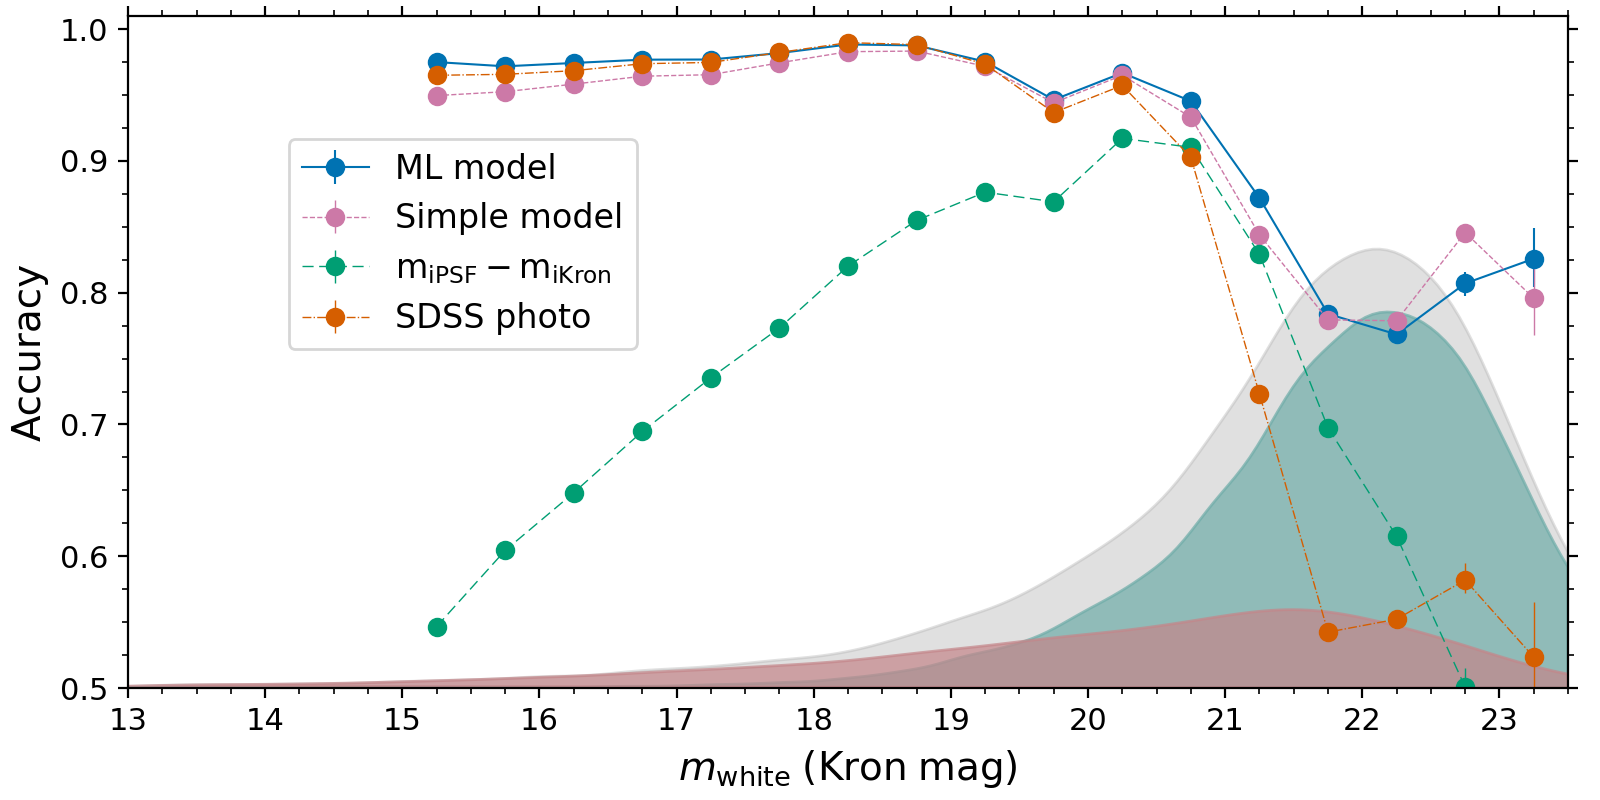

In [18]:
fig, ax = plt.subplots(figsize=(8,4))

ax.errorbar(mag_bin_centers[4:], ml_resamp_arr[4:], 
            yerr=np.abs(ml_resamp_scatt - ml_resamp_arr)[:,4:], 
            ls =ls_dict['ml'], lw=.75, fmt='o',
            color=color_dict['ml'], label="ML model")
ax.errorbar(mag_bin_centers[4:], simple_resamp_arr[4:], 
            yerr=np.abs(simple_resamp_scatt - simple_resamp_arr)[:,4:], 
            ls =ls_dict['simple'], lw=.5, fmt='o',
            color=color_dict['simple'], label="Simple model")
ax.errorbar(mag_bin_centers[4:], ps1_resamp_arr[4:], 
            yerr=np.abs(ps1_resamp_scatt - ps1_resamp_arr)[:,4:], 
            ls =ls_dict['ps1'], lw=.5, dashes=(8, 4), fmt='o',
            color=color_dict['ps1'], label=r'm$_{\rm iPSF}-$m$_{\rm iKron}$')
ax.errorbar(mag_bin_centers[4:], sdss_resamp_arr[4:], 
            yerr=np.abs(sdss_resamp_scatt - sdss_resamp_arr)[:,4:], 
            ls=ls_dict['sdss'], lw=.5, fmt='o',
            color=color_dict['sdss'], label="SDSS photo")

# add KDE plots
ax.fill(np.append(kde_grid, 23.5), 
        np.append(pdf_hst, 0) + 0.5, alpha=0.4, color="0.7")
ax.fill(np.append(kde_grid, 23.5), 
        np.append(pdf_hst_gal*hst_kde_gal_norm, 0) + 0.5, alpha=0.7, color=cmap_gal(0.25))
ax.fill(np.append(kde_grid, 23.5), 
        np.append(pdf_hst_stars*hst_kde_star_norm, 0) + 0.5, alpha=0.7, color=cmap_star(0.25))

ax.set_ylim(0.5,1.01)
ax.set_xlim(13, 23.5)
ax.tick_params(which="both", top=True, right=True, labelsize=11)
ax.set_xlabel('$m_\mathrm{white} \; (\mathrm{Kron \; mag})$', fontsize=14)
ax.set_ylabel('Accuracy', fontsize=14)

ax.yaxis.set_minor_locator(MultipleLocator(0.025))
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_minor_locator(MultipleLocator(0.25))

ax.legend(bbox_to_anchor=(0.1, 0.48),
          loc=3, fontsize=12)

fig.subplots_adjust(top=0.98,right=0.98,left=0.08,bottom=0.14)


## Put all 3 plots together for 1 figure

<IPython.core.display.Javascript object>


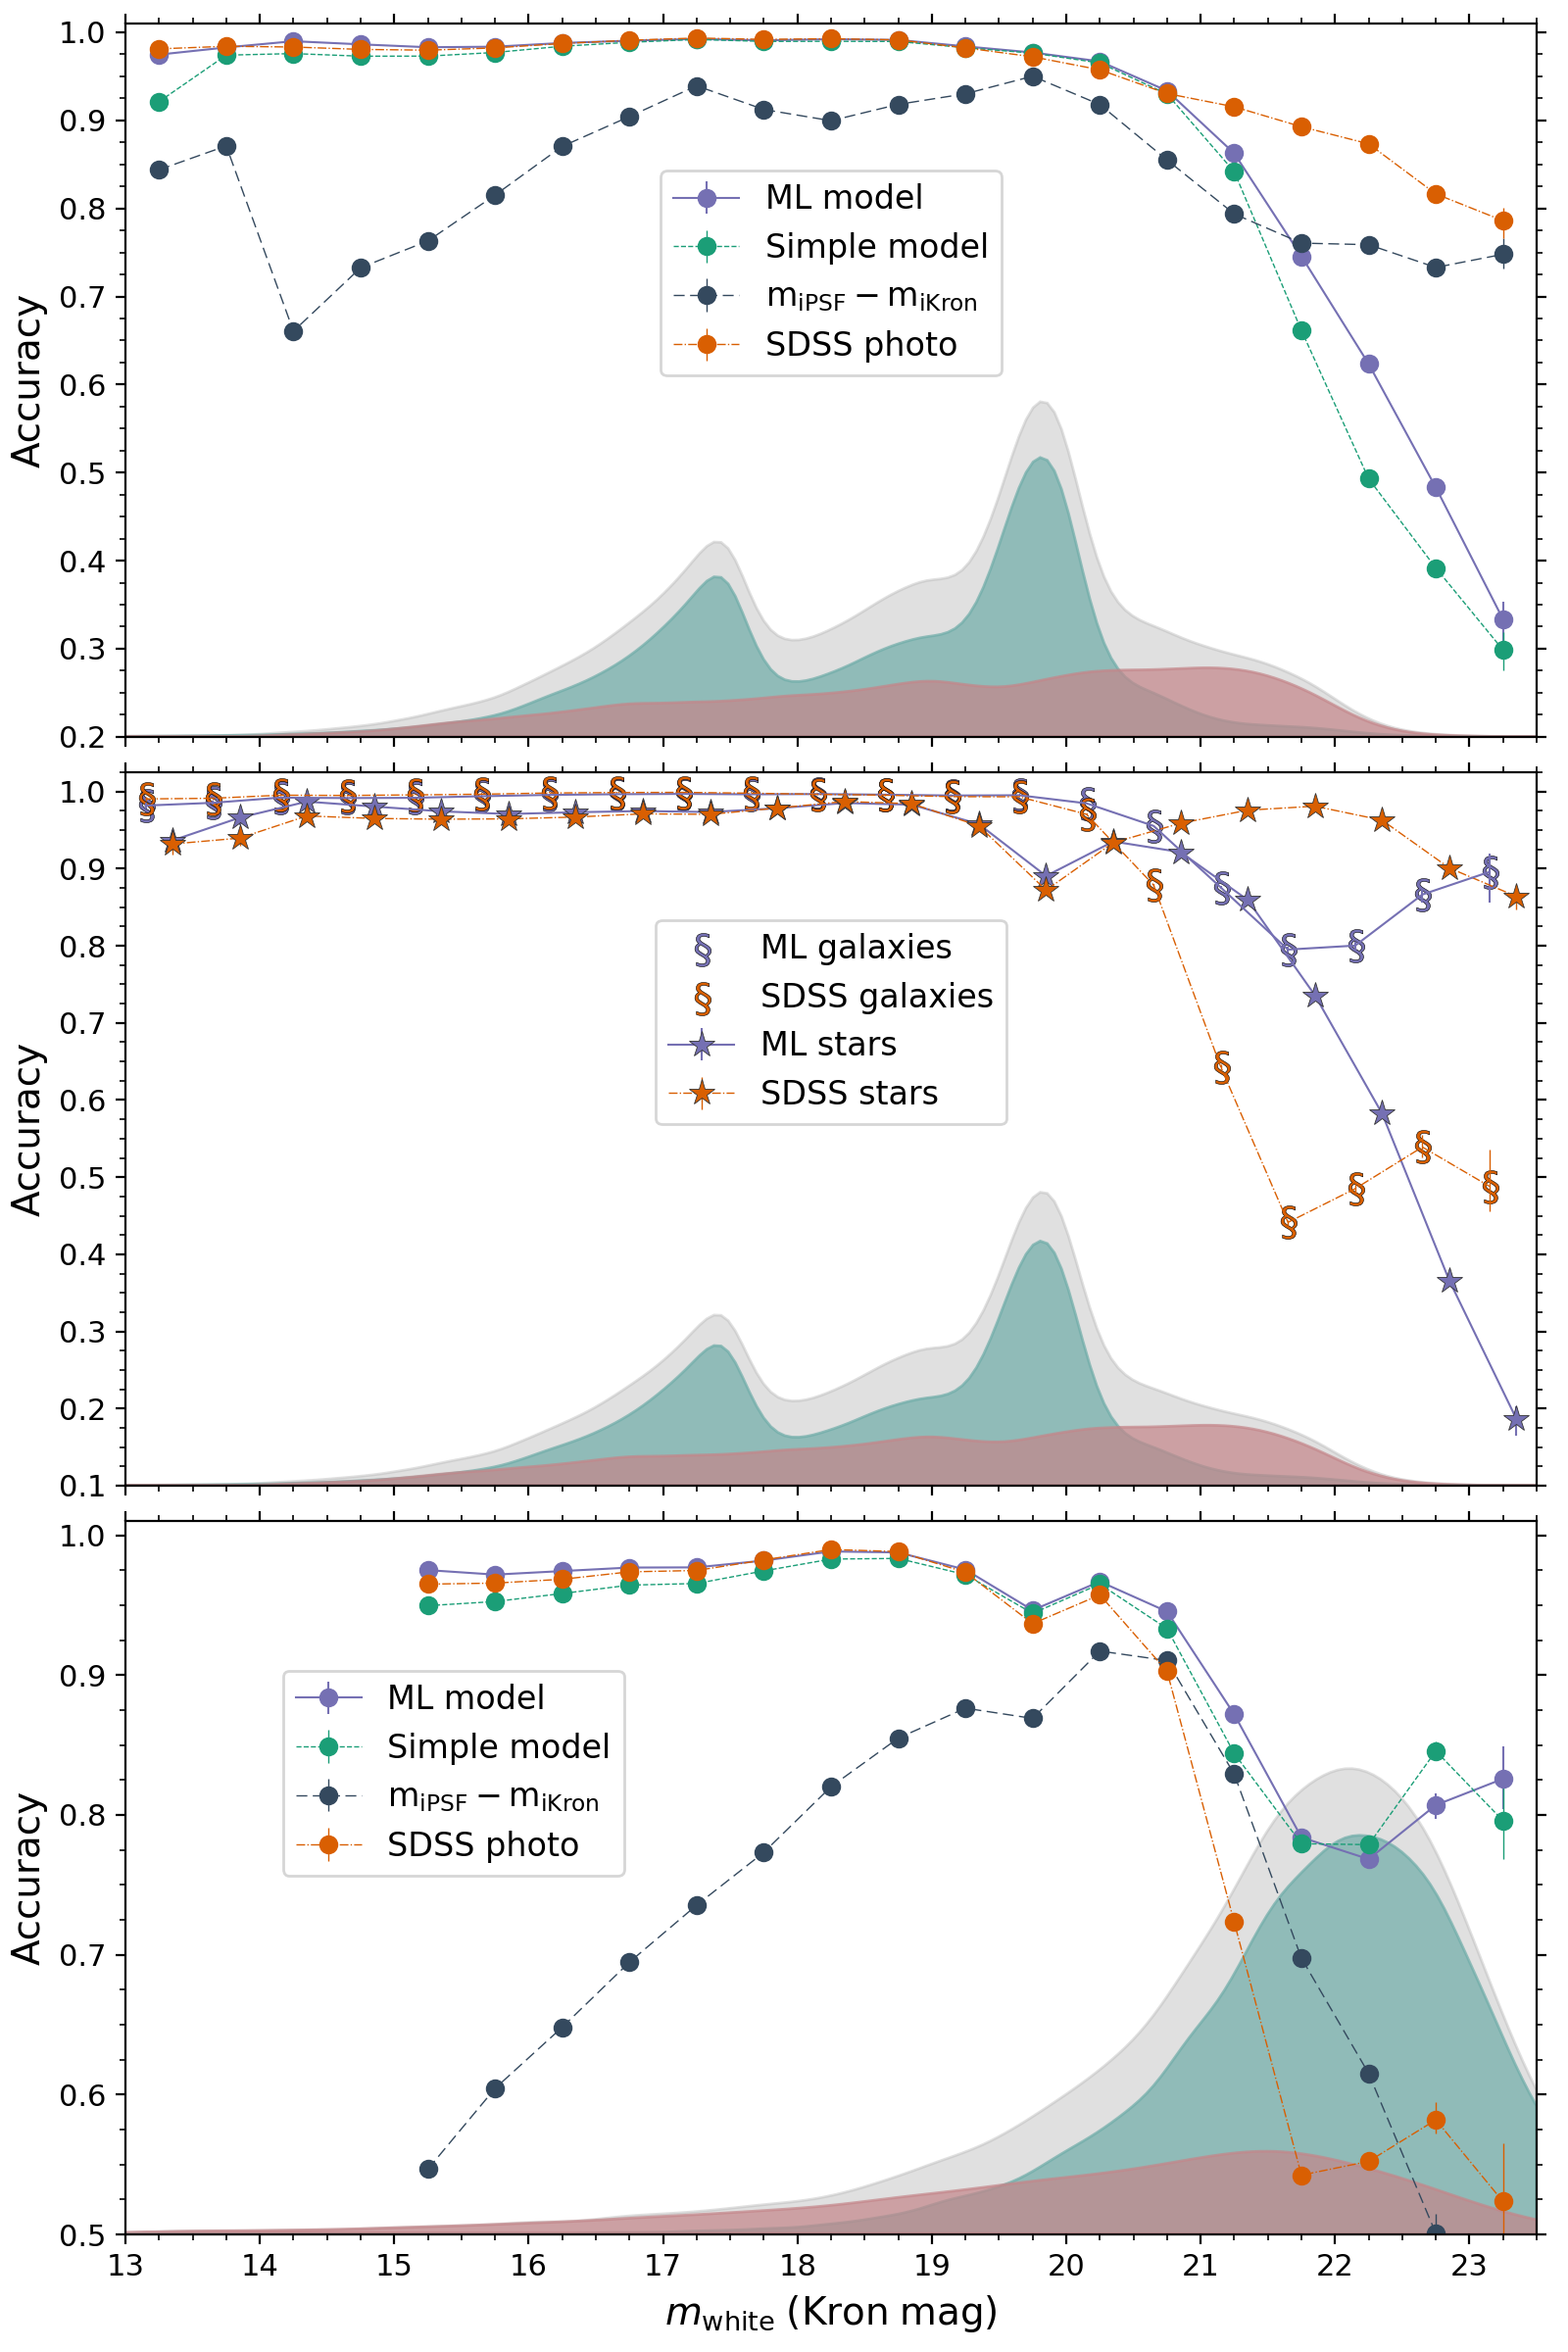

In [34]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(8,12))

# raw plot of everything
ax1.errorbar(mag_bin_centers, ml_acc_arr, 
            yerr=np.abs(ml_boot_scatt - ml_acc_arr), 
            ls =ls_dict['ml'], lw=.75, fmt='o',
            color=color_dict['ml'], label="ML model")
ax1.errorbar(mag_bin_centers, simple_acc_arr, 
            yerr=np.abs(simple_boot_scatt - simple_acc_arr), 
            ls =ls_dict['simple'], lw=.5, fmt='o',
            color=color_dict['simple'], label="Simple model")
ax1.errorbar(mag_bin_centers, ps1_acc_arr, 
            yerr=np.abs(ps1_boot_scatt - ps1_acc_arr), 
            ls =ls_dict['ps1'], lw=.5, dashes=(8, 4), fmt='o',
            color=color_dict['ps1'], label=r'm$_{\rm iPSF}-$m$_{\rm iKron}$')
ax1.errorbar(mag_bin_centers, sdss_acc_arr, 
            yerr=np.abs(sdss_boot_scatt - sdss_acc_arr), 
            ls=ls_dict['sdss'], lw=.5, fmt='o',
            color=color_dict['sdss'], label="SDSS photo")

# add KDE plots
ax1.fill(kde_grid, pdf_sdss + 0.2, alpha=0.4, color="0.7")
ax1.fill(kde_grid, pdf_sdss_gal*sdss_kde_gal_norm + 0.2, alpha=0.7, color=cmap_gal(0.25))
ax1.fill(kde_grid, pdf_sdss_stars*sdss_kde_star_norm + 0.2, alpha=0.7, color=cmap_star(0.25))

ax1.set_ylim(0.2,1.01)
ax1.set_xlim(13, 23.5)
ax1.tick_params(which="both", top=True, right=True, labelsize=11)
ax1.set_ylabel('Accuracy', fontsize=14)

ax1.yaxis.set_minor_locator(MultipleLocator(0.025))

ax1.legend(bbox_to_anchor=(0.5, 0.65),
          loc=10, fontsize=12)

# plot stars and galaxies
ax2.errorbar(mag_bin_centers+0.1, ml_star_acc_arr, 
            yerr=np.abs(ml_star_boot_scatt - ml_star_acc_arr), 
            ls =ls_dict['ml'], lw=.75, fmt='*', ms=10,
            mec="0.2", mew=0.3,
            color=color_dict['ml'], label="ML stars")
ax2.errorbar(mag_bin_centers+0.1, sdss_star_acc_arr, 
            yerr=np.abs(sdss_star_boot_scatt - sdss_star_acc_arr), 
            ls=ls_dict['sdss'], lw=.5, fmt='*', ms=10,
            mec="0.2", mew=0.3,
            color=color_dict['sdss'], label="SDSS stars")


ax2.scatter(mag_bin_centers-0.1, ml_gal_acc_arr, 
           marker=r'$\S$', s=150, edgecolor='k', linewidths=0.2,
           color=color_dict['ml'], label="ML galaxies")
ax2.errorbar(mag_bin_centers-0.1, ml_gal_acc_arr, 
            yerr=np.abs(ml_gal_boot_scatt - ml_gal_acc_arr), 
            ls =ls_dict['ml'], lw=.75, fmt=',',
            color=color_dict['ml'])
ax2.scatter(mag_bin_centers-0.1, sdss_gal_acc_arr, 
           marker=r'$\S$', s=150, edgecolor='k', linewidths=0.2,
           color=color_dict['sdss'], label="SDSS galaxies")
ax2.errorbar(mag_bin_centers-0.1, sdss_gal_acc_arr, 
            yerr=np.abs(sdss_gal_boot_scatt - sdss_gal_acc_arr), 
            ls=ls_dict['sdss'], lw=.5, fmt=',',
            color=color_dict['sdss'])

# add KDE plots
ax2.fill(kde_grid, pdf_sdss + 0.1, alpha=0.4, color="0.7")
ax2.fill(kde_grid, pdf_sdss_gal*sdss_kde_gal_norm + 0.1, alpha=0.7, color=cmap_gal(0.25))
ax2.fill(kde_grid, pdf_sdss_stars*sdss_kde_star_norm + 0.1, alpha=0.7, color=cmap_star(0.25))

ax2.set_ylim(0.1,1.025)
ax2.tick_params(which="both", top=True, right=True, labelsize=11)
ax2.set_ylabel('Accuracy', fontsize=14)

ax2.yaxis.set_major_locator(MultipleLocator(0.1))
ax2.yaxis.set_minor_locator(MultipleLocator(0.025))
ax2.xaxis.set_major_locator(MultipleLocator(1))
ax2.xaxis.set_minor_locator(MultipleLocator(0.25))

ax2.legend(bbox_to_anchor=(0.5, 0.65),
          loc=10, fontsize=12)

# plot the corrected accuracies
ax3.errorbar(mag_bin_centers[4:], ml_resamp_arr[4:], 
            yerr=np.abs(ml_resamp_scatt - ml_resamp_arr)[:,4:], 
            ls =ls_dict['ml'], lw=.75, fmt='o',
            color=color_dict['ml'], label="ML model")
ax3.errorbar(mag_bin_centers[4:], simple_resamp_arr[4:], 
            yerr=np.abs(simple_resamp_scatt - simple_resamp_arr)[:,4:], 
            ls =ls_dict['simple'], lw=.5, fmt='o',
            color=color_dict['simple'], label="Simple model")
ax3.errorbar(mag_bin_centers[4:], ps1_resamp_arr[4:], 
            yerr=np.abs(ps1_resamp_scatt - ps1_resamp_arr)[:,4:], 
            ls =ls_dict['ps1'], lw=.5, dashes=(8, 4), fmt='o',
            color=color_dict['ps1'], label=r'm$_{\rm iPSF}-$m$_{\rm iKron}$')
ax3.errorbar(mag_bin_centers[4:], sdss_resamp_arr[4:], 
            yerr=np.abs(sdss_resamp_scatt - sdss_resamp_arr)[:,4:], 
            ls=ls_dict['sdss'], lw=.5, fmt='o',
            color=color_dict['sdss'], label="SDSS photo")

# add KDE plots
ax3.fill(np.append(kde_grid, 23.5), 
        np.append(pdf_hst, 0) + 0.5, alpha=0.4, color="0.7")
ax3.fill(np.append(kde_grid, 23.5), 
        np.append(pdf_hst_gal*hst_kde_gal_norm, 0) + 0.5, alpha=0.7, color=cmap_gal(0.25))
ax3.fill(np.append(kde_grid, 23.5), 
        np.append(pdf_hst_stars*hst_kde_star_norm, 0) + 0.5, alpha=0.7, color=cmap_star(0.25))

ax3.set_ylim(0.5,1.01)
# ax3.set_xlim(13, 23.5)
ax3.tick_params(which="both", top=True, right=True, labelsize=11)
ax3.set_ylabel('Accuracy', fontsize=14)
ax3.set_xlabel('$m_\mathrm{white} \; (\mathrm{Kron \; mag})$', fontsize=14)

ax3.yaxis.set_minor_locator(MultipleLocator(0.025))
ax3.xaxis.set_major_locator(MultipleLocator(1))
ax3.xaxis.set_minor_locator(MultipleLocator(0.25))

ax3.legend(bbox_to_anchor=(0.1, 0.48),
          loc=3, fontsize=12)

fig.subplots_adjust(top=0.99,right=0.98,left=0.08,bottom=0.05, hspace=0.05)
fig.savefig("/Users/adamamiller/Desktop/SDSS_acc_mag.pdf")